<a href="https://colab.research.google.com/github/Xnsam/machine_learning_prax/blob/master/dbpedia_doc_vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [0]:
!mkdir -p ~/.kaggle
!echo '{"username":"aksonsam","key":"5878bc124e8992538e03c7d4f5258cd5"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d danofer/dbpedia-classes

 89% 148M/166M [00:02<00:00, 48.2MB/s]
100% 166M/166M [00:02<00:00, 70.4MB/s]


In [3]:
!unzip db*.zip

Archive:  dbpedia-classes.zip
  inflating: DBPEDIA_test.csv        
  inflating: DBPEDIA_train.csv       
  inflating: DBPEDIA_val.csv         
  inflating: DBP_wiki_data.csv       


# Doc 2 Vec

In [0]:
import pandas as pd
import numpy as np

In [5]:
train_df = pd.read_csv('DBPEDIA_train.csv')
train_df.head()

,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding


In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re

In [0]:
pattern = re.compile(r'[a-zA-Z0-9]+')

def word_tokenize(d):
  """A function to split the sentences."""
  tmp = []
  words = pattern.findall(d)
  tmp.extend([i for i in words])
  return tmp

In [0]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(tag)]) for _d, tag in zip(train_df.text.tolist(), train_df.l1.tolist())]

In [9]:
tagged_data[:5]

[TaggedDocument(words=['william', 'alexander', 'massey', 'october', '7', '1856', 'march', '5', '1914', 'was', 'a', 'united', 'states', 'senator', 'from', 'nevada', 'born', 'in', 'trumbull', 'county', 'ohio', 'he', 'moved', 'with', 'his', 'parents', 'to', 'edgar', 'county', 'illinois', 'in', '1865', 'he', 'attended', 'the', 'common', 'schools', 'union', 'christian', 'college', 'in', 'merom', 'indiana', 'and', 'the', 'indiana', 'asbury', 'university', 'now', 'de', 'pauw', 'university', 'in', 'greencastle', 'indiana', 'he', 'studied', 'law', 'and', 'was', 'admitted', 'to', 'the', 'bar', 'in', '1877', 'commencing', 'practice', 'in', 'sullivan', 'indiana', 'he', 'moved', 'to', 'san', 'diego', 'california', 'in', '1886', 'and', 'to', 'nevada', 'in', '1887', 'where', 'he', 'prospected', 'and', 'mined', 'and', 'later', 'took', 'up', 'the', 'practice', 'of', 'law', 'in', 'elko', 'nevada', 'massey', 'was', 'a', 'member', 'of', 'the', 'nevada', 'assembly', 'from', '1892', 'to', '1894', 'and', 'wa

In [0]:
def train_model(**kwargs):
  """A function to train the model."""
  model = Doc2Vec(vector_size=kwargs['size'],
                  alpha=kwargs['alpha'],
                  min_alpha=kwargs['min_alpha'], 
                  min_count=kwargs['min_count'],
                  dm=kwargs['dm']
                  )
  print('Building vocab...')
  model.build_vocab(kwargs['tagged_data'])
  for epoch in range(kwargs['epochs']):
    print('running itr [{}]'.format(epoch))
    model.train(kwargs['tagged_data'],
                total_examples=model.corpus_count,
                epochs=model.epochs,
                )
    model.alpha -= 0.0002
    model.min_alpha = model.min_alpha
  
  model.save('d2v.model')
  print('Model Saved')
  return model

In [11]:
model = train_model(size=3, alpha=0.025, min_alpha=0.00025, min_count=1, dm=1, epochs=1, tagged_data=tagged_data, workers=4)

Building vocab...
running itr [0]


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [12]:
test_df = pd.read_csv('DBPEDIA_test.csv')
test_df.head()

,text,l1,l2,l3
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Agent,Politician,PrimeMinister
1,"Michelle Maylene (born January 20, 1987) is an...",Agent,Actor,AdultActor
2,Hirfanlı Dam is a dam in Turkey. The developme...,Place,Infrastructure,Dam
3,Grote Prijs Stad Zottegem is a single-day road...,Event,Race,CyclingRace
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Agent,Athlete,MartialArtist


In [0]:
test_df['predicted_l1'] = test_df['text'].apply(lambda x : model.infer_vector(word_tokenize(x.lower())))

In [14]:
test_df.head()

,text,l1,l2,l3,predicted_l1
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Agent,Politician,PrimeMinister,"[0.081861, -0.24129777, 0.0921147]"
1,"Michelle Maylene (born January 20, 1987) is an...",Agent,Actor,AdultActor,"[0.088241845, -0.15955974, -0.105383046]"
2,Hirfanlı Dam is a dam in Turkey. The developme...,Place,Infrastructure,Dam,"[-0.01833657, -0.28043786, -0.010170116]"
3,Grote Prijs Stad Zottegem is a single-day road...,Event,Race,CyclingRace,"[0.05763644, -0.73716915, 0.090583466]"
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Agent,Athlete,MartialArtist,"[0.07947284, -0.71079516, 0.03274835]"


In [15]:
test_df.l1.value_counts(), test_df.l1.value_counts() / test_df.shape[0]

(Agent             31495
 Place             11574
 Species            5418
 Work               5300
 Event              4820
 SportsSeason       1483
 UnitOfWork          444
 TopicalConcept      198
 Device               62
 Name: l1, dtype: int64, Agent             0.518061
 Place             0.190381
 Species           0.089121
 Work              0.087180
 Event             0.079284
 SportsSeason      0.024394
 UnitOfWork        0.007303
 TopicalConcept    0.003257
 Device            0.001020
 Name: l1, dtype: float64)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (11.2, 8.27)})
sns.set_style('whitegrid')

In [0]:
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [20]:
test_df.head()

,text,l1,l2,l3,predicted_l1
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Agent,Politician,PrimeMinister,"[0.081861, -0.24129777, 0.0921147]"
1,"Michelle Maylene (born January 20, 1987) is an...",Agent,Actor,AdultActor,"[0.088241845, -0.15955974, -0.105383046]"
2,Hirfanlı Dam is a dam in Turkey. The developme...,Place,Infrastructure,Dam,"[-0.01833657, -0.28043786, -0.010170116]"
3,Grote Prijs Stad Zottegem is a single-day road...,Event,Race,CyclingRace,"[0.05763644, -0.73716915, 0.090583466]"
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Agent,Athlete,MartialArtist,"[0.07947284, -0.71079516, 0.03274835]"


In [0]:
import pdb

In [0]:
def plot_dim_reduce(matrix, color_code_element, algo='lda'):
  """A function to plot the dimensionality reduced  algorithm. """

  np.random.seed(42)
  color_labels = color_code_element.unique().tolist()
  rgb_values = sns.color_palette('Set2', len(color_labels))
  color_map = dict(zip(color_labels, rgb_values))

  if algo is 'lda':
    print('Fitting LDA')
    red_dim = LDA(n_components=2)
    red_dim.fit(matrix, color_code_element)
    print('Explained variance ratio', red_dim.explained_variance_ratio_)
    matrix_reduced = red_dim.transform(matrix)
  else:
    print('Fitting PCA')
    red_dim = PCA(n_components=2)
    red_dim.fit(matrix)
    print('Explained variance ratio', red_dim.explained_variance_ratio_)
    matrix_reduced = red_dim.transform(matrix)

  # pdb.set_trace()

  tmp_df = pd.DataFrame({'x': matrix_reduced[:, 0], 'y': matrix_reduced[:, 1], 'event': color_code_element})

  plt.scatter(tmp_df['x'], tmp_df['y'], color=tmp_df['event'].map(color_map))
  plt.title('{} word2vec cluster plot'.format(algo))
  plt.show()

In [0]:
matrix = [i.tolist() for i in test_df['predicted_l1']]
matrix = np.array(matrix)

In [42]:
matrix.shape

(60794, 3)

Fitting LDA
Explained variance ratio [0.62838462 0.34752381]


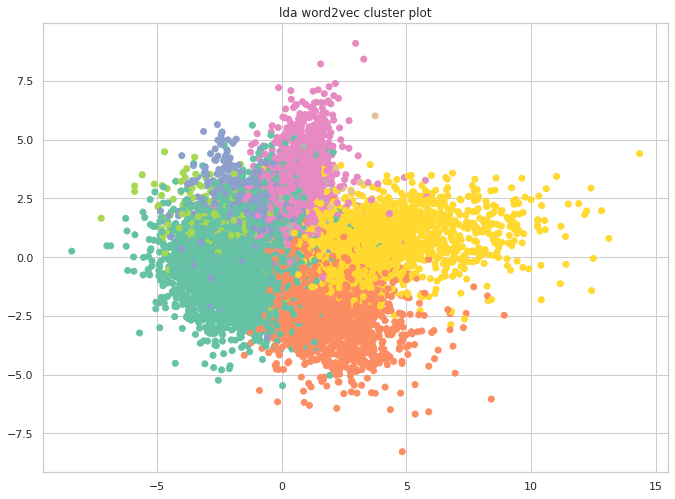

In [75]:
plot_dim_reduce(matrix, test_df['l1'], 'lda')

Fitting PCA
Explained variance ratio [0.75810322 0.15262722]


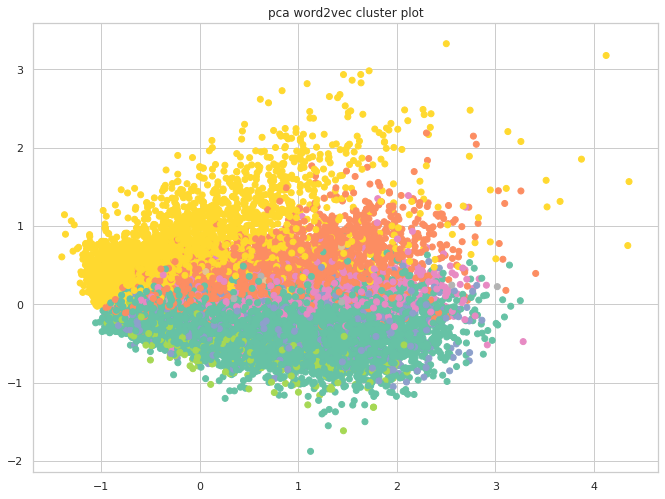

In [76]:
plot_dim_reduce(matrix, test_df['l1'], 'pca')